<a href="https://colab.research.google.com/github/Patatone/Network-failure-cause-identification/blob/main/Failure_cause_identification_with_different_failures_location_IPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from itertools import chain

C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)
    
    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y



In [4]:
def train_classifier_XGB(X_train, y_train): 
    xgb = XGBClassifier(use_label_encoder=False, eta = 0.7, max_depth= 19, subsample = 0.7, verbosity = 0)
    
    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        xgb.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return xgb, ttimes

In [5]:
def train_classifier_DNN(X_train, y_train): 
    size = (10,) * 3
    dnn = MLPClassifier(hidden_layer_sizes=size, activation='logistic',
                                solver='adam', learning_rate='invscaling', max_iter=1000)
    
    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        dnn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return dnn, ttimes

In [6]:
def train_classifier_KNN(X_train, y_train): 
    knn = KNeighborsClassifier(leaf_size=21, p=2, n_neighbors=4)
    
    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        knn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return knn, ttimes

In [7]:
########################################################################################################
###### The function performance_eval() takes in input ground truth and predicted labels, 
###### prints results in a result file passed in input, and returns global metrics
########################################################################################################

def performance_eval(y_true, y_pred, lab, l_names):

    #Compute metrics and print/write them
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None) #F: average=None gives per-class results
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted') 
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted') 
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    return accuracy, global_precision, global_recall, global_f1score 

In [8]:
windowrange=[3, 5, 10, 30, 75, 150, 300]
samplingrange=[3]

A_XGB = np.zeros([len(samplingrange),len(windowrange)])
GP_XGB = np.zeros([len(samplingrange),len(windowrange)])
GR_XGB = np.zeros([len(samplingrange),len(windowrange)])
GF1_XGB = np.zeros([len(samplingrange),len(windowrange)])

A_DNN = np.zeros([len(samplingrange),len(windowrange)])
GP_DNN = np.zeros([len(samplingrange),len(windowrange)])
GR_DNN = np.zeros([len(samplingrange),len(windowrange)])
GF1_DNN = np.zeros([len(samplingrange),len(windowrange)])

A_KNN = np.zeros([len(samplingrange),len(windowrange)])
GP_KNN = np.zeros([len(samplingrange),len(windowrange)])
GR_KNN = np.zeros([len(samplingrange),len(windowrange)])
GF1_KNN = np.zeros([len(samplingrange),len(windowrange)])

def training_loop(windowrange, samplingrange):
    global A_XGB, GP_XGB, GR_XGB, GF1_XGB
    global A_DNN, GP_DNN, GR_DNN, GF1_DNN
    global A_KNN, GP_KNN, GR_KNN, GF1_KNN
    
    xgb_all_ttimes = []
    dnn_all_ttimes = []
    knn_all_ttimes = []
    
    lbl = [0, 1]
    label_names=['Attenuation', 'Filtering']

    spacing = 1
    
    for i, sampling in enumerate(samplingrange): #enumerate(range(minsp,maxsp+1,stepsp)):
        for j, length in enumerate(windowrange): #enumerate(range(minlength,maxlength+1,steplength)):
            print('********************************')
            print('Iteration for spacing={}, window length={}, sampling length={}'.format(spacing, length, sampling))

            ####### 1) Load dataset #######
            print('1) Loading dataset into (XX,yy)...')

            XX = None
            yy = None
            folderpath='../Features_1_8'

            for filename in os.listdir(folderpath):
                if filename.endswith('_sa' + str(sampling)+'_sp' + str(spacing) + '_w' + str(length) + '.dat'):
                    label = 0
                    if int(filename[9]) > 5:
                        label = 1
                    fullname = folderpath + '/' + filename
                    XX, yy = load_window_dataset(XX, yy, fullname, label)

            scaler = StandardScaler()
            XX = scaler.fit_transform(XX)

            X_train, X_test, y_train, y_test = train_test_split(XX, yy, stratify=yy, test_size=0.3, random_state=42)
            print('Training XGB...')
            xgb, xgb_ttimes = train_classifier_XGB(X_train, y_train)

            print('Training DNN...')
            dnn, dnn_ttimes = train_classifier_DNN(X_train, y_train)

            print('Training KNN...')
            knn, knn_ttimes = train_classifier_KNN(X_train, y_train)

            xgb_all_ttimes.append(xgb_ttimes)
            dnn_all_ttimes.append(dnn_ttimes)
            knn_all_ttimes.append(knn_ttimes)

            y_pred_XGB = xgb.predict(X_test)
            y_pred_DNN = dnn.predict(X_test)
            y_pred_KNN = knn.predict(X_test)

            A_XGB[i,j], GP_XGB[i,j], GR_XGB[i,j], GF1_XGB[i,j] = performance_eval(y_test, y_pred_XGB, lbl, label_names)
            A_DNN[i,j], GP_DNN[i,j], GR_DNN[i,j], GF1_DNN[i,j] = performance_eval(y_test, y_pred_DNN, lbl, label_names)
            A_KNN[i,j], GP_KNN[i,j], GR_KNN[i,j], GF1_KNN[i,j] = performance_eval(y_test, y_pred_KNN, lbl, label_names)

    return xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes

In [9]:
def candle_trainng_size_impact(fig_folder, alg_name, ttimes, windowrange, samplingrange):
    if len(samplingrange) == 1:
        considered_range = windowrange
        valutation_type = 'Window length'
    else:
        considered_range = samplingrange
        valutation_type = 'Sampling length'
        
    fig, ax = plt.subplots(figsize=(15,8))
    bplots = []
    n_perc = len(considered_range)
    
    for i in range(n_perc):
        bplots.append(ax.boxplot(ttimes[i], positions = [i], patch_artist=True))

    for bplot in bplots:
        for patch in bplot['boxes']:
            patch.set_facecolor('lightblue')
    
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.grid(1)
    plt.xticks(ticks = list(range(n_perc)), labels = [str(x) for x in considered_range], fontsize = 14)
    plt.setp(ax.xaxis.get_majorticklabels(), ha="center") 
    plt.ylabel('Seconds', color='black', fontsize=14)
    title=alg_name+' '+ valutation_type+' impact on Traning Time with '
    if len(windowrange) == 1:
        title = title + 'W=' + str(windowrange[0]) + 'and S=1'
    else:
        title = title + 'SA=' + str(samplingrange[0]) + 'and S=1'
        
    plt.title(title, fontsize=14)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 
    plt.show()
    fig.savefig(fig_folder+'/'+title.replace(" ", "_")+'.png')

In [10]:
fig_folder = '1_8_Figures'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes = training_loop(windowrange, samplingrange)

********************************
Iteration for spacing=1, window length=3, sampling length=3
1) Loading dataset into (XX,yy)...
Training XGB...
6.344119071960449
6.652853488922119
6.7548041343688965
Training DNN...
6.901334762573242
24.90277361869812
19.203874111175537
Training KNN...
0.04274296760559082
0.053412675857543945
0.044550180435180664
********************************
Iteration for spacing=1, window length=5, sampling length=3
1) Loading dataset into (XX,yy)...
Training XGB...
5.848718166351318
5.813229560852051
6.448063373565674
Training DNN...
22.333789825439453
15.277906656265259
29.595959186553955
Training KNN...
0.0446934700012207
0.05302786827087402
0.05076956748962402
********************************
Iteration for spacing=1, window length=10, sampling length=3
1) Loading dataset into (XX,yy)...
Training XGB...
4.2812206745147705
4.861518144607544
4.696904182434082
Training DNN...
9.496398448944092
8.788923263549805
10.65265417098999
Training KNN...
0.043463945388793945

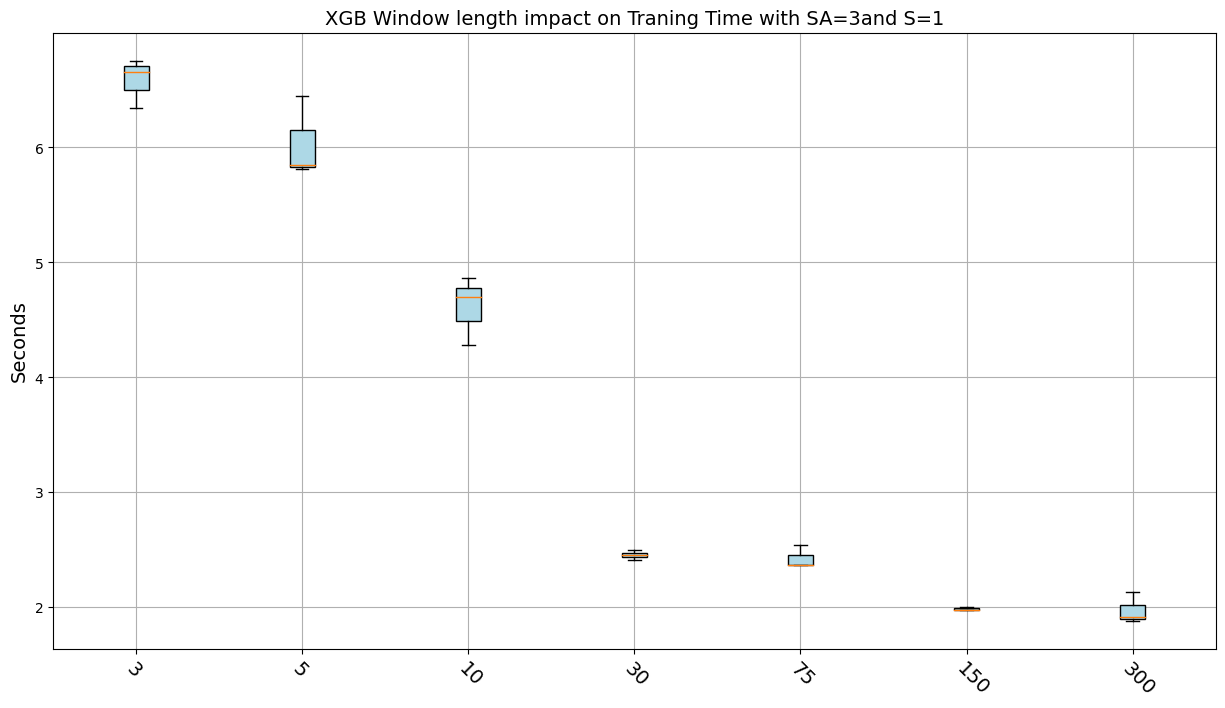

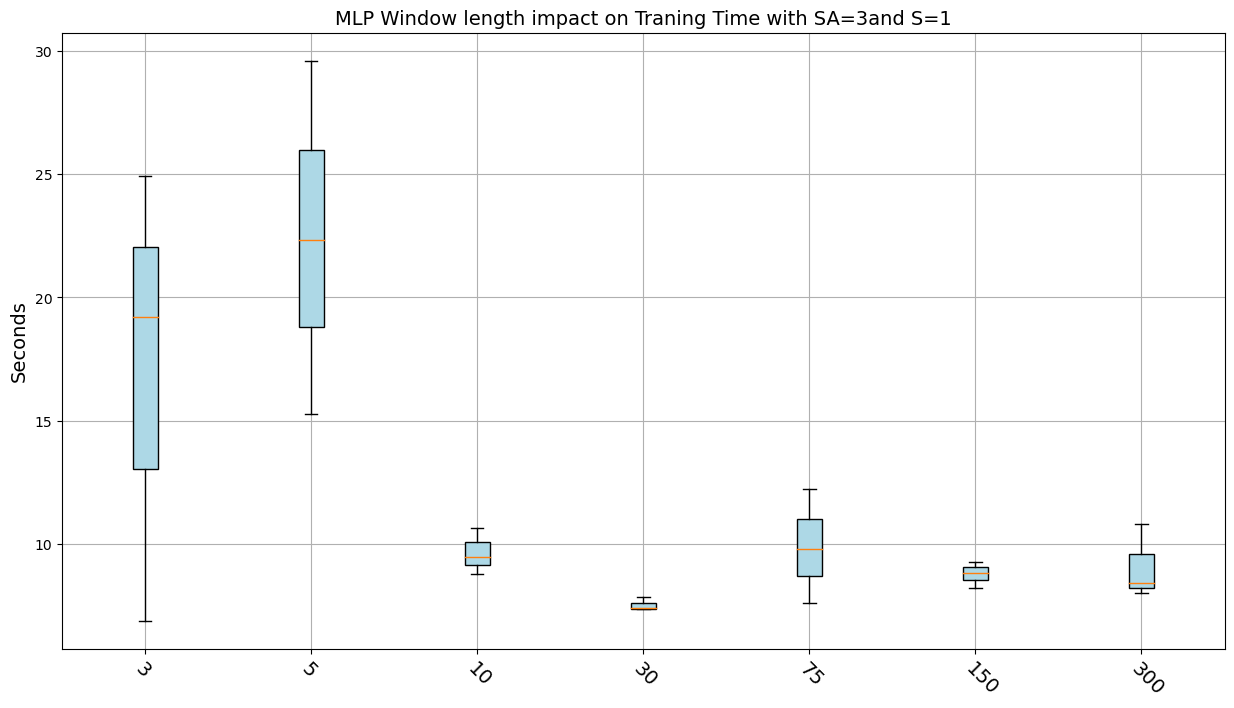

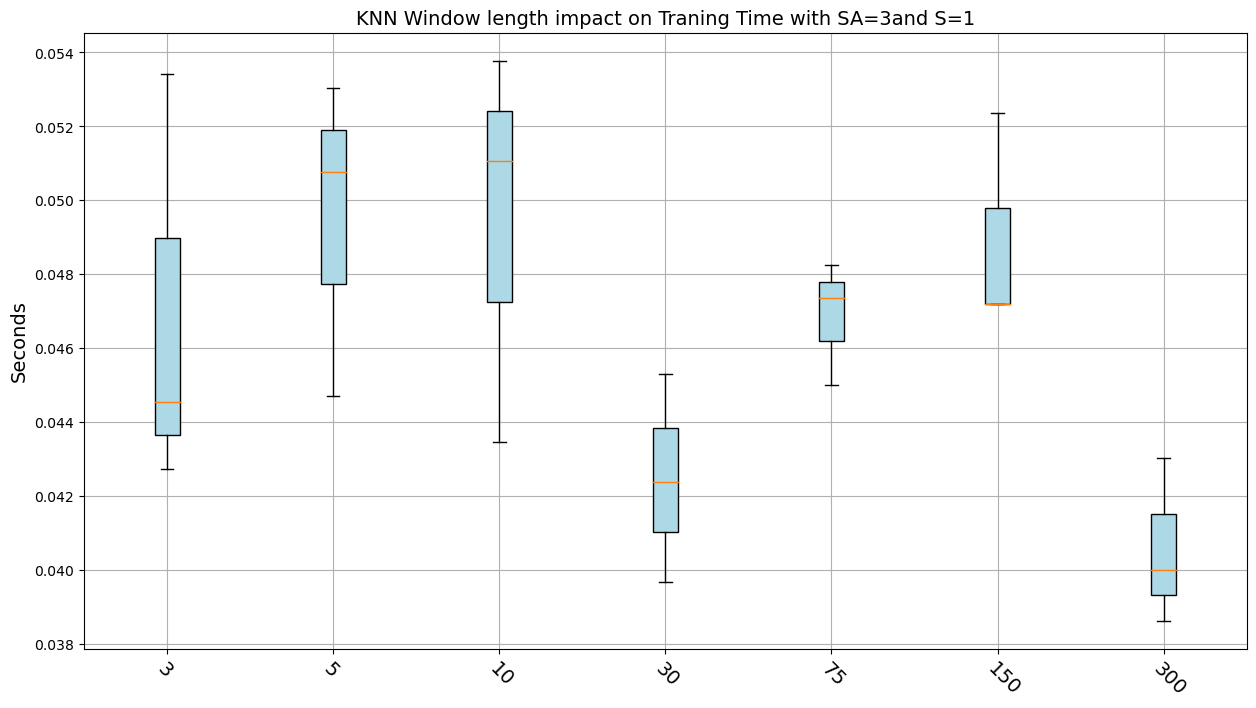

In [12]:
candle_trainng_size_impact(fig_folder, 'XGB', xgb_all_ttimes, windowrange, samplingrange)
candle_trainng_size_impact(fig_folder, 'MLP', dnn_all_ttimes, windowrange, samplingrange)
candle_trainng_size_impact(fig_folder, 'KNN', knn_all_ttimes, windowrange, samplingrange)

In [13]:
###############################################################################
###### Windows
###############################################################################

def draw_summary_plot(fig_folder, a_limit, b_limit, windowrange, samplingrange):

    global A_XGB, GP_XGB, GR_XGB, GF1_XGB
    global A_DNN, GP_DNN, GR_DNN, GF1_DNN
    global A_KNN, GP_KNN, GR_KNN, GF1_KNN
    
    xvalues = None
    if len(windowrange) == 1:
        xvalues=np.array(samplingrange)
        subject = 'Sampling'
    else:
        xvalues=np.array(windowrange)
        subject = 'Window'

    A_XGB = A_XGB.reshape(-1, 1)
    GP_XGB = GP_XGB.reshape(-1, 1)
    GR_XGB = GR_XGB.reshape(-1, 1)
    GF1_XGB = GF1_XGB.reshape(-1, 1)

    A_DNN = A_DNN.reshape(-1, 1)
    GP_DNN = GP_DNN.reshape(-1, 1)
    GR_DNN = GR_DNN.reshape(-1, 1)
    GF1_DNN = GF1_DNN.reshape(-1, 1)

    A_KNN = A_KNN.reshape(-1, 1)
    GP_KNN = GP_KNN.reshape(-1, 1)
    GR_KNN = GR_KNN.reshape(-1, 1)
    GF1_KNN = GF1_KNN.reshape(-1, 1)

    fig, axs = plt.subplots(2, 2, sharex='all', figsize=(20,15))

    axs[0,0].plot(xvalues[a_limit:b_limit], A_XGB[a_limit:b_limit], label = 'XGB')
    axs[0,0].plot(xvalues[a_limit:b_limit], A_DNN[a_limit:b_limit], label = 'DNN')
    axs[0,0].plot(xvalues[a_limit:b_limit], A_KNN[a_limit:b_limit], label = 'KNN')
    axs[0,0].set_xticks(xvalues)
    axs[0,0].tick_params(labelrotation=55)
    axs[0,0].set_title('Accuracy')
    axs[0,0].set_ylabel('Accuracy')
    axs[0,0].yaxis.grid(True)

    axs[0,1].plot(xvalues[a_limit:b_limit], GP_XGB[a_limit:b_limit], label = 'XGB')
    axs[0,1].plot(xvalues[a_limit:b_limit], GP_DNN[a_limit:b_limit], label = 'DNN')
    axs[0,1].plot(xvalues[a_limit:b_limit], GP_KNN[a_limit:b_limit], label = 'KNN')
    axs[0,1].set_title('Precision')
    axs[0,1].set_ylabel('Precision')
    axs[0,1].tick_params(labelrotation=55)
    axs[0,1].yaxis.grid(True)

    axs[1,0].plot(xvalues[a_limit:b_limit], GR_XGB[a_limit:b_limit], label = 'XGB')
    axs[1,0].plot(xvalues[a_limit:b_limit], GR_DNN[a_limit:b_limit], label = 'DNN')
    axs[1,0].plot(xvalues[a_limit:b_limit], GR_KNN[a_limit:b_limit], label = 'KNN')
    axs[1,0].set_title('Recall')
    axs[1,0].set_ylabel('Recall')
    axs[1,0].tick_params(labelrotation=55)
    axs[1,0].yaxis.grid(True)

    axs[1,1].plot(xvalues[a_limit:b_limit], GF1_XGB[a_limit:b_limit], label = 'XGB')
    axs[1,1].plot(xvalues[a_limit:b_limit], GF1_DNN[a_limit:b_limit], label = 'DNN')
    axs[1,1].plot(xvalues[a_limit:b_limit], GF1_KNN[a_limit:b_limit], label = 'KNN')
    axs[1,1].set_title('F1-Score')
    axs[1,1].set_ylabel('F1-Score')
    axs[1,1].tick_params(labelrotation=55)
    axs[1,1].yaxis.grid(True)

    axs[1,0].set_xlabel(subject+' length, s')
    axs[1,1].set_xlabel(subject+' length, s')

    axs[1,1].legend(loc='best')

    title = 'Impact of ' + subject + ' length with '
    if len(windowrange) == 1:
        title = title + 'W=' + str(windowrange[0]) + ' and S=1'
    else:
        title = title + 'SA=' + str(samplingrange[0]) + ' and S=1'
    
    fig.suptitle(title)
    
    fig.tight_layout()
    fig.savefig(fig_folder+'/'+str(a_limit)+'_'+str(b_limit)+'_'+subject+'_duration.png')

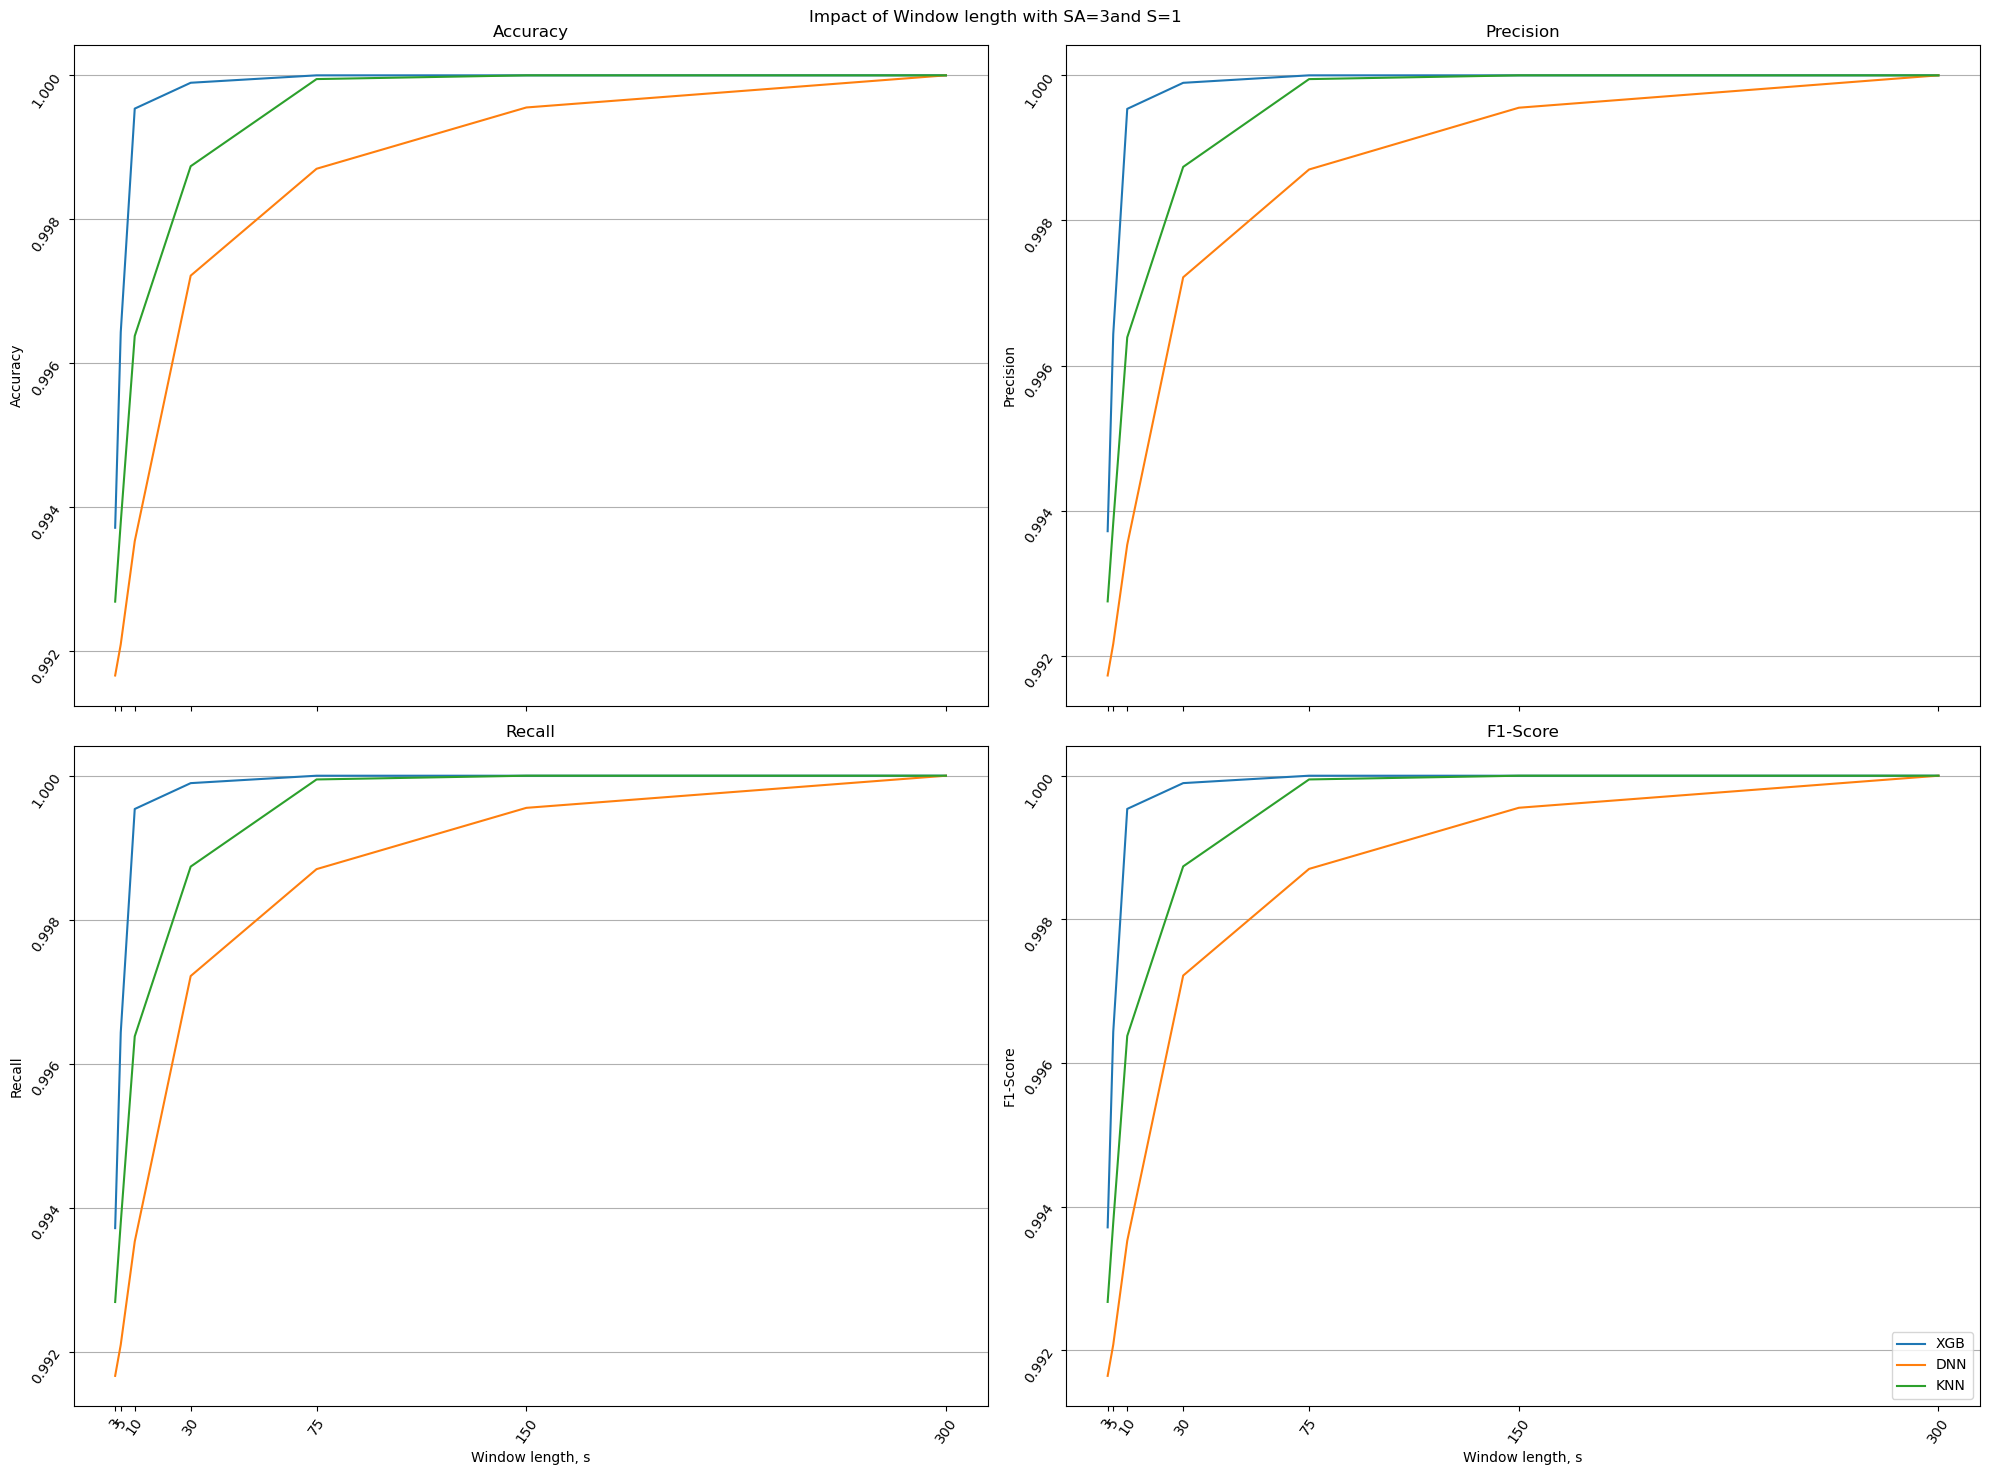

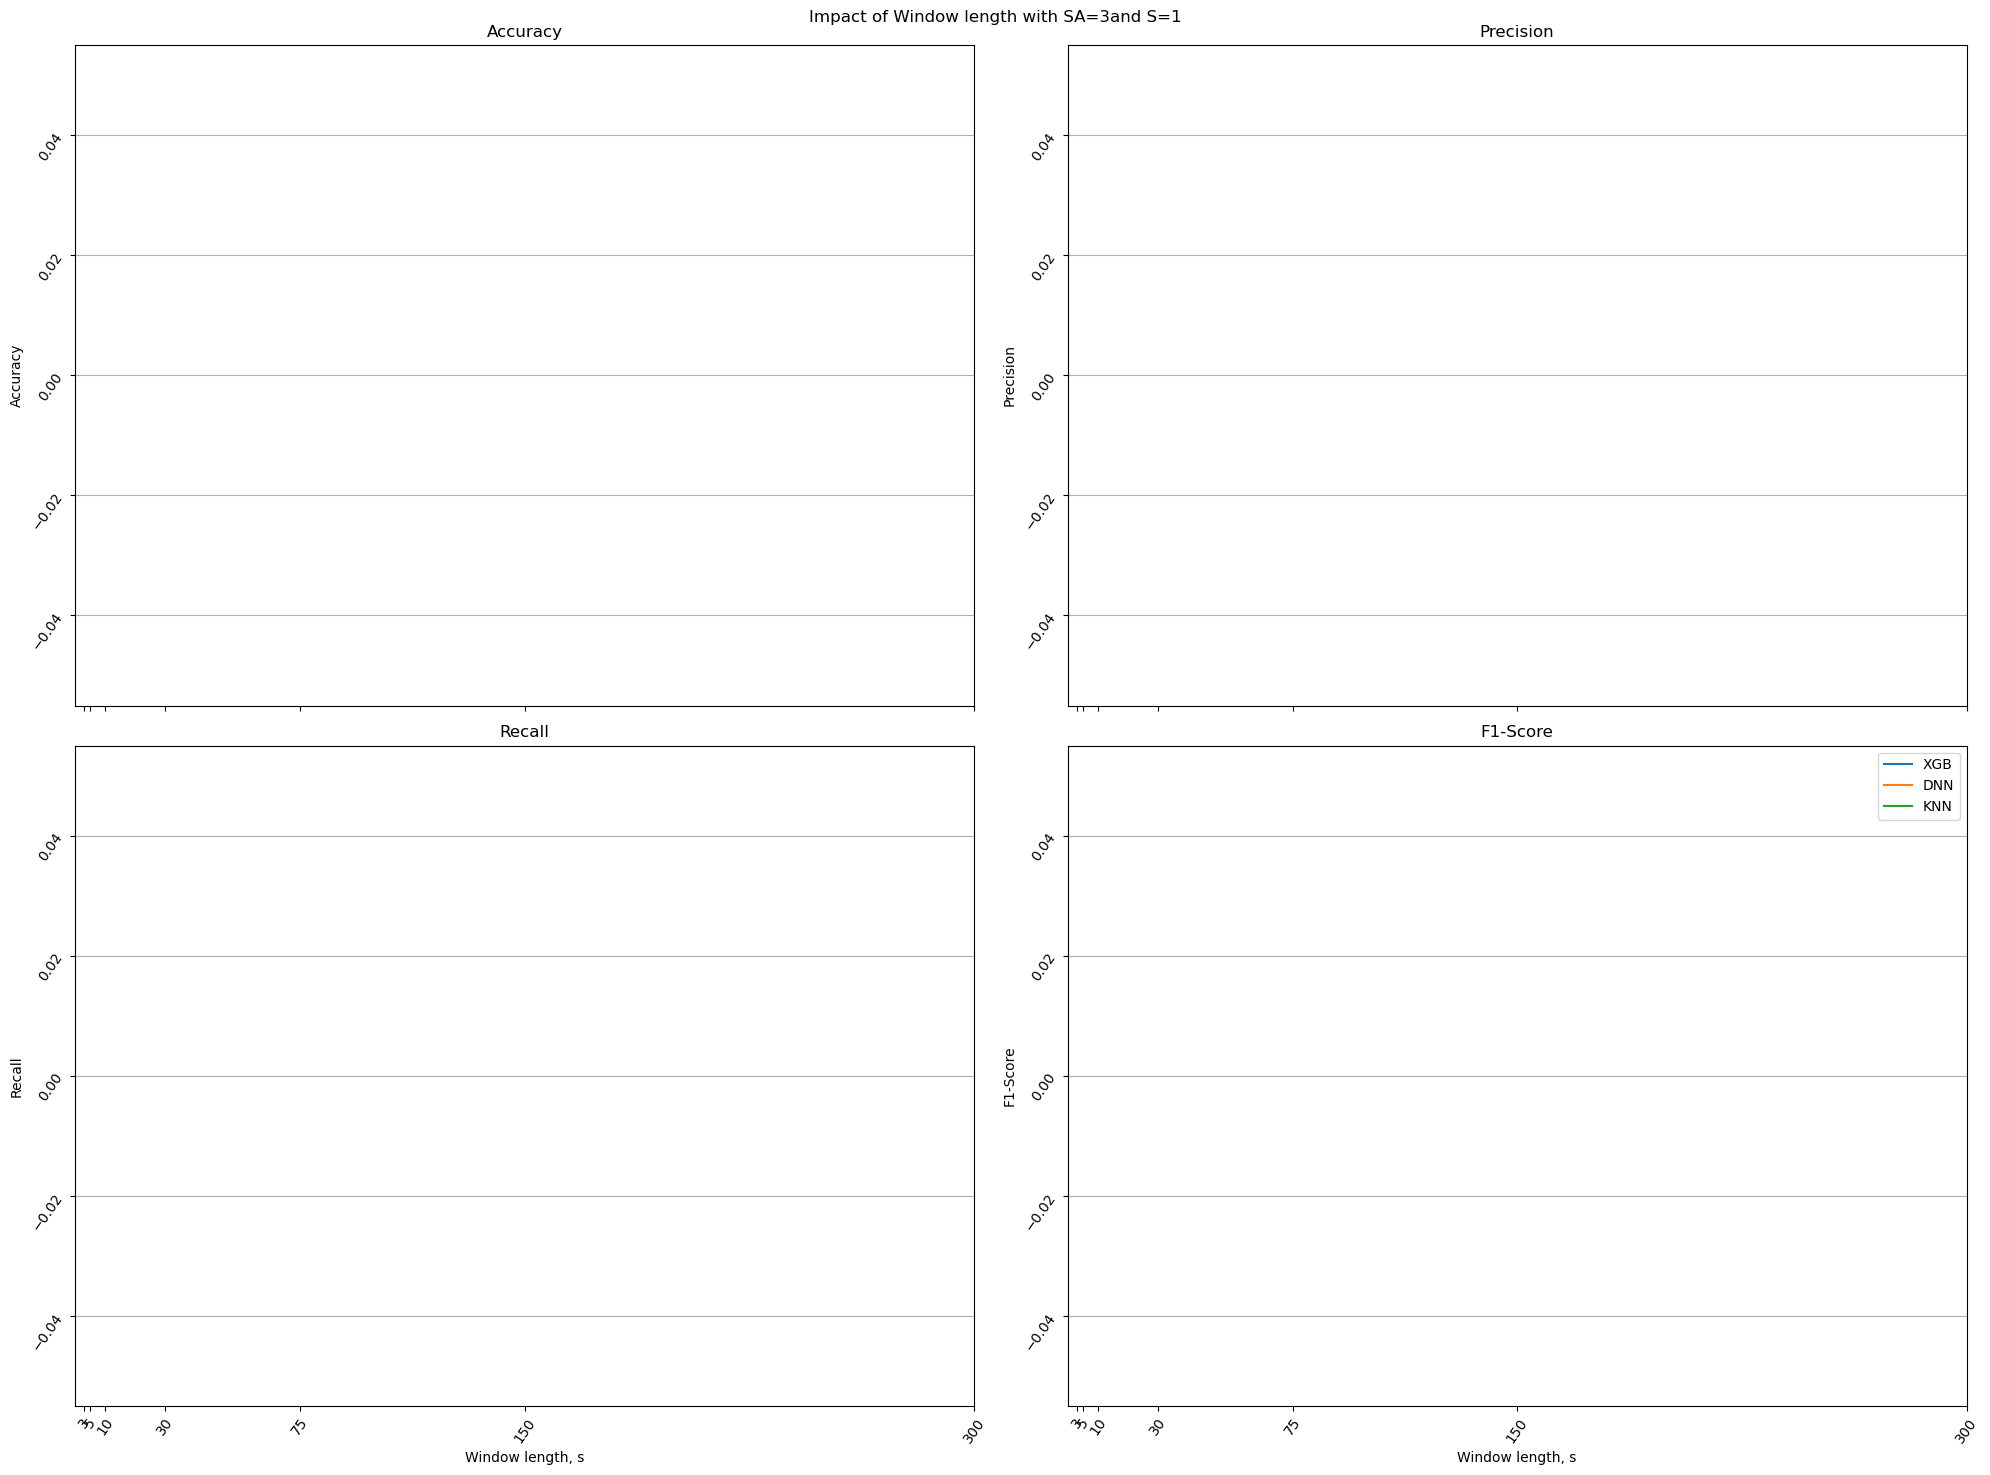

In [14]:
# Window Specific view
draw_summary_plot(fig_folder, 0, 10, windowrange, samplingrange)

# Window Global view
draw_summary_plot(fig_folder, 9, 15, windowrange, samplingrange)

In [15]:
###############################################################################
###### sampling
###############################################################################
windowrange=[10]
samplingrange=[1, 2, 3, 5, 10]

A_XGB = np.zeros([len(samplingrange),len(windowrange)])
GP_XGB = np.zeros([len(samplingrange),len(windowrange)])
GR_XGB = np.zeros([len(samplingrange),len(windowrange)])
GF1_XGB = np.zeros([len(samplingrange),len(windowrange)])

A_DNN = np.zeros([len(samplingrange),len(windowrange)])
GP_DNN = np.zeros([len(samplingrange),len(windowrange)])
GR_DNN = np.zeros([len(samplingrange),len(windowrange)])
GF1_DNN = np.zeros([len(samplingrange),len(windowrange)])

A_KNN = np.zeros([len(samplingrange),len(windowrange)])
GP_KNN = np.zeros([len(samplingrange),len(windowrange)])
GR_KNN = np.zeros([len(samplingrange),len(windowrange)])
GF1_KNN = np.zeros([len(samplingrange),len(windowrange)])

training_loop(windowrange, samplingrange)

********************************
Iteration for spacing=1, window length=10, sampling length=1
1) Loading dataset into (XX,yy)...
Training XGB...
15.917141675949097
15.827513694763184


KeyboardInterrupt: 

In [ ]:
candle_trainng_size_impact(fig_folder, 'XGB', xgb_all_ttimes, windowrange, samplingrange)
candle_trainng_size_impact(fig_folder, 'MLP', dnn_all_ttimes, windowrange, samplingrange)
candle_trainng_size_impact(fig_folder, 'KNN', knn_all_ttimes, windowrange, samplingrange)

In [ ]:
# sampling Global view
draw_summary_plot(fig_folder, 0, len(A_KNN), windowrange, samplingrange)